In [1]:
import pickle
import pandas as pd

In [2]:
from random import randrange, uniform
def generate_power_cons():
    power_cons = {
        "main_power": 0,
        "propeller_system": uniform(100, 150),
        "guidance_system": uniform(10, 15),
        "light": uniform(0.1,0.5),
        "emergency_power": 50,
        "sail_guidance_system":uniform(20,50),
        "electrical_applicances": uniform(1,5),
        "microplastic_system": uniform(15,20),
        "diagnostic_system": uniform(0.1,0.5),
        "temperate_regulation": uniform(30,40)
    }

    return power_cons

In [3]:
# load
df = pd.read_csv('simulation_values.csv')
file_name = "xgb_reg_model_power.pkl"
sim_values = x_test = df[['Day of Year', 'First Hour of Period', 'Is Daylight', 'Distance to Solar Noon', 
'Average Temperature (Day)', 'Average Wind Direction (Day)', 'Average Wind Speed (Day)', 'Sky Cover','Visibility', 
'Relative Humidity', 'Average Wind Speed (Period)','Average Barometric Pressure (Period)']].values
xgb_model_loaded = pickle.load(open(file_name, "rb"))
result = xgb_model_loaded.predict(sim_values)

In [4]:
arr = [["main_power", -1], ["propeller_system", 2], 
["guidance_system",3], ["light",8], ["emergency_power",1], ["sail_guidance_system",5], 
["electrical_applicances",6], ["microplastic_system",7], ["diagnostic_system",4], ["temperature_regulation",9] ]
priority_list = {j:i for i,j in arr}
priority_list

{-1: 'main_power',
 2: 'propeller_system',
 3: 'guidance_system',
 8: 'light',
 1: 'emergency_power',
 5: 'sail_guidance_system',
 6: 'electrical_applicances',
 7: 'microplastic_system',
 4: 'diagnostic_system',
 9: 'temperature_regulation'}

In [5]:
graph = {
    "main_power": ["propeller_system", "emergency_power"],
    "propeller_system": ["microplastic_system", "light", "emergency_power"],
    "light": ["guidance_system", "electrical_applicances", "emergency_power"],
    "guidance_system": ["sail_guidance_system"],
    "sail_guidance_system": ["diagnostic_system", "emergency_power"],
    "microplastic_system": ["emergency_power"],
    "diagnostic_system": [],
    "emergency_power": ["propeller_system"],
    'electrical_applicances': []
    
}


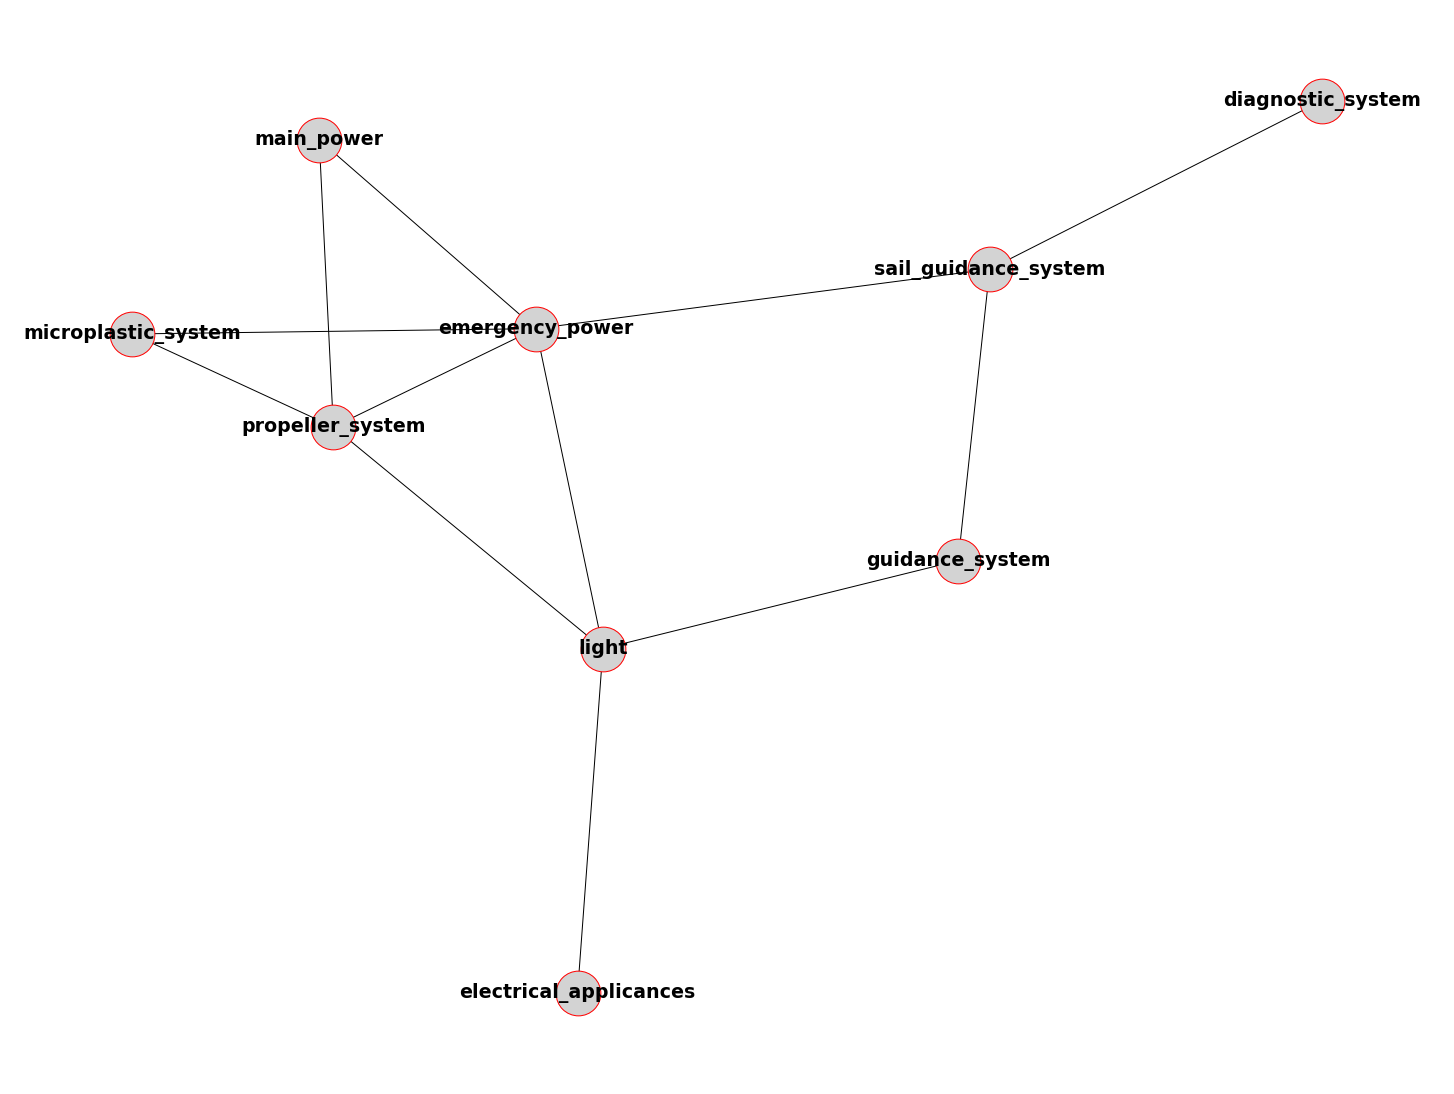

In [6]:

# First networkx library is imported 
# along with matplotlib
import networkx as nx
import matplotlib.pyplot as plt
   
  
class GraphVisualization:
   
    def __init__(self):
          
        self.visual = []

    def addEdge(self, a, b):
        temp = [a, b]
        self.visual.append(temp)
          
    def visualize(self):
        plt.figure(figsize=(20,15)) 
        G = nx.Graph()
        G.add_edges_from(self.visual)
        nx.draw(G, with_labels=True, edgecolors='red', font_size=19, font_weight="bold", node_color='lightgray', node_size=2000)
        plt.show()
  

G = GraphVisualization()
for i in graph:
    for j in graph[i]:
        G.addEdge(i, j)
G.visualize()

In [7]:
def shortest_path(graph, source, dest, visited = set()):
    visited = set([source])
    prev = {}
    queue = [[source,0]]
    node_path = set()

    while len(queue)>0:
        # print(queue)
        node, distance = queue.pop(0)
        if node == dest:
            return distance, prev
        
        for neighbours in graph[node]:
            if neighbours not in visited:
                if node not in prev:
                    prev[node] = set()
                prev[node].add(neighbours)
                visited.add(neighbours)
                queue.append([neighbours, distance +1])

    return -1, prev

#Edge List

dist, paths = shortest_path(graph, "main_power", "emergency_power")
print(paths, dist)
def find_shortest_path_nodes(graph, paths, dest, dist,path = set()):

    if dest not in graph:
        return [] 
    while len(path)-1 < dist:
        path.add(dest)
        for i in paths:
            if dest in paths[i]:
                dest = i

    return path
print(find_shortest_path_nodes(graph, paths,"emergency_power", dist))

{'main_power': {'propeller_system', 'emergency_power'}, 'propeller_system': {'microplastic_system', 'light'}} 1
{'main_power', 'emergency_power'}


In [8]:
arr = [1,2,3,4,5,6]
item = arr.pop()
print(arr[-1])

5


In [9]:
import random
input_values = sim_values[random.randint(0,525)]
result = xgb_model_loaded.predict([input_values])
print(result[0])

26638.99


In [10]:
import random
import time
from IPython.display import clear_output

while True:
    print("************* Iteration Starts ***********")
    input_values = sim_values[random.randint(0,525)]  # Getting the values of current environment parameters at this instant
    power_generated = xgb_model_loaded.predict([input_values])  #Using ML to predict the power that will be generated in the next hour, through environmental parameters
    power_consumption = generate_power_cons()  # Fetcing the record of power that has been consumed by differnt components of the ship
    source = "main_power"  # We ll start distribution from the main power
    nodes_covered = set()  
    power_remaining = power_generated[0]/70 if power_generated[0]>0 else 0 # Predicted value of power generated, all the power remaining no consumption yet
    print("Power Generated In this Instant:",power_remaining)
    print("Power Consumption of Components in past hour", power_consumption)
    for start in range(10):
        #Initializing Priority List
        if start in priority_list:
            end = priority_list[start]    # Fetch the top priority element 
            print("Source: ",source, "|| Destination: ",end)  # Current Source and Destination Node/Component
            dist, paths = shortest_path(graph, source, end, visited = set())  # Finding the shortest path between those 2 Nodes, source and Destination
            nodes = find_shortest_path_nodes(graph, paths, end, dist, path = set()) # Listing all the components that lie in this path
            for i in nodes:
                if i not in nodes_covered:                       # If the Componenet hasn't already powered up
                    power_remaining = power_remaining - power_consumption[i]  # Subtracting the power consmption of the current component

                nodes_covered.add(i)   # Adding the current componenets that have been covered to an array

            if power_remaining < 0:  # if consumption falls below 0, then we ll break out of the current iteration
                break

            source = end   # Current Destination will be out new source
    print("Nodes Covered: ", nodes_covered)
    print("Power Remaining: ",power_remaining if power_remaining > 0 else 0)
    print("^^ Remaining Power Will Go to Emergency Reserve ^^")
    print("*********** Iteration Ends *************")
    time.sleep(20) # Sleep for 3 seconds
    clear_output(wait=True)

************* Iteration Starts ***********
Power Generated In this Instant: 366.0125279017857
Power Consumption of Components in past hour {'main_power': 0, 'propeller_system': 105.6766633955007, 'guidance_system': 12.946392172201254, 'light': 0.45282251090080883, 'emergency_power': 50, 'sail_guidance_system': 33.75254698468282, 'electrical_applicances': 2.7400016230999396, 'microplastic_system': 17.62260727593616, 'diagnostic_system': 0.4554464228638654, 'temperate_regulation': 39.76194139647368}
Source:  main_power || Destination:  emergency_power
Source:  emergency_power || Destination:  propeller_system
Source:  propeller_system || Destination:  guidance_system
Source:  guidance_system || Destination:  diagnostic_system
Source:  diagnostic_system || Destination:  sail_guidance_system
Source:  sail_guidance_system || Destination:  electrical_applicances
Source:  electrical_applicances || Destination:  microplastic_system
Source:  microplastic_system || Destination:  light
Source:  l